In [33]:
import pandas as pd
from sklearn.metrics import *
from tqdm import tqdm
from utils import HeteroDataProcessor
import numpy as np

In [28]:

# Usage
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

time_cut =1e10

processor = HeteroDataProcessor(file_path_replies, file_path_posts, time_cut)
data = processor.process()


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


In [130]:
data'

HeteroData(
  id={
    x=[2002, 106],
    y=[2002],
    train_mask=[2002],
    val_mask=[2002],
    test_mask=[2002],
  },
  reply_user_id={ x=[14440, 104] },
  (id, retweet, reply_user_id)={ edge_index=[2, 14440] },
  (reply_user_id, rev_retweet, id)={ edge_index=[2, 14440] }
)

In [133]:
test_mask = data['id'].test_mask

In [136]:
data['id'].y[test_mask].sum()

tensor(69)

In [138]:
data['id'].y[test_mask].shape

torch.Size([301])

In [2]:
import torch
import torch.nn.functional as F
from torch import nn

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HANConv, Linear


class HAN(nn.Module):
    def __init__(self, dim_in, dim_out, dim_h=64, heads=4):
        super().__init__()
        self.han = HANConv(dim_in, dim_h, heads=heads,dropout=0.4, metadata=data.metadata())
        self.linear = nn.Linear(dim_h, dim_out)

    def forward(self, x_dict, edge_index_dict):
        out = self.han(x_dict, edge_index_dict)
        out = self.linear(out['id'])
        return out



@torch.no_grad()
def test(mask):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    acc = (pred[mask] == data['id'].y[mask]).sum() / mask.sum()
    return float(acc)



In [47]:

model = HAN(dim_in=-1, dim_out=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)


for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['id'].train_mask
    loss = F.cross_entropy(out[mask], data['id'].y[mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_acc = test(data['id'].train_mask)
        val_acc = test(data['id'].val_mask)
        print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

test_acc = test(data['id'].test_mask)
print(f'Test accuracy: {test_acc*100:.2f}%')

Epoch:   0 | Train Loss: 0.8318 | Train Acc: 35.97% | Val Acc: 34.33%
Epoch:  20 | Train Loss: 0.7506 | Train Acc: 70.24% | Val Acc: 73.67%
Epoch:  40 | Train Loss: 0.5700 | Train Acc: 70.38% | Val Acc: 74.00%
Epoch:  60 | Train Loss: 0.5302 | Train Acc: 69.88% | Val Acc: 73.33%
Epoch:  80 | Train Loss: 0.5329 | Train Acc: 71.66% | Val Acc: 74.67%
Epoch: 100 | Train Loss: 0.4794 | Train Acc: 73.73% | Val Acc: 75.67%
Epoch: 120 | Train Loss: 0.4718 | Train Acc: 81.58% | Val Acc: 80.67%
Epoch: 140 | Train Loss: 0.4416 | Train Acc: 82.94% | Val Acc: 80.00%
Epoch: 160 | Train Loss: 0.4417 | Train Acc: 83.51% | Val Acc: 81.67%
Epoch: 180 | Train Loss: 0.4053 | Train Acc: 85.51% | Val Acc: 82.67%
Epoch: 200 | Train Loss: 0.4160 | Train Acc: 85.94% | Val Acc: 81.67%
Epoch: 220 | Train Loss: 0.3787 | Train Acc: 87.29% | Val Acc: 82.67%
Epoch: 240 | Train Loss: 0.3498 | Train Acc: 88.08% | Val Acc: 83.33%
Epoch: 260 | Train Loss: 0.3548 | Train Acc: 88.87% | Val Acc: 84.33%
Epoch: 280 | Train L

In [49]:
test_mask = data['id'].test_mask | data['id'].val_mask
pred =model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
true_labels = data['id'].y[test_mask]
pred_labels = pred[test_mask]
precision_score(true_labels, pred_labels, average='macro')

0.7672193634457785

In [50]:
recall_score(true_labels, pred_labels, average='macro')

0.7414084022038567

In [26]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("HAN  1 layer 2024-09-05")

2024/09/07 00:26:39 INFO mlflow.tracking.fluent: Experiment with name 'HAN  1 layer 2024-09-05' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/14', creation_time=1725668799400, experiment_id='14', last_update_time=1725668799400, lifecycle_stage='active', name='HAN  1 layer 2024-09-05', tags={}>

In [27]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range(1,30,1):
    print(time_cut)
    processor = HeteroDataProcessor(file_path_replies, file_path_posts, time_cut)
    data = processor.process()

    model = HAN(dim_in=-1, dim_out=2)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
   
    with mlflow.start_run():

        for epoch in range(500):
            model.train()
            optimizer.zero_grad()
            out = model(data.x_dict, data.edge_index_dict)
            mask = data['id'].train_mask
            loss = F.cross_entropy(out[mask], data['id'].y[mask])
            loss.backward()
            optimizer.step()

        if epoch % 20 == 0:
            train_acc = test(data['id'].train_mask)
            val_acc = test(data['id'].val_mask)
            print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

        test_acc = test(data['id'].test_mask)
        print(f'Test accuracy: {test_acc*100:.2f}%')



        test_mask = data['id'].test_mask | data['id'].val_mask
        pred =model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
        true_labels = data['id'].y[test_mask]
        pred_labels = pred[test_mask]
        test_precision =precision_score(true_labels, pred_labels, average='macro')
        test_recall=recall_score(true_labels, pred_labels, average='macro')
        print(f'Test Recall: {test_recall*100:.2f}%')
        print(f'Test Precision: {test_precision*100:.2f}%')

        mlflow.log_metric("train_loss", loss.item(), step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("test_acc", test_acc)
        mlflow.log_metric("test_precision",  test_precision)
        mlflow.log_metric("test_recall",  test_recall)

            
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("epochs", 400)
        mlflow.log_metric("time_cut", time_cut)



        
            
        mlflow.pytorch.log_model(model, f"HAN_model_{time_cut}")


1


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 78.74%
Test Recall: 55.38%
Test Precision: 63.58%


2024/09/07 00:30:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 79.07%
Test Recall: 60.11%
Test Precision: 69.91%


2024/09/07 00:30:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 77.74%
Test Recall: 61.65%
Test Precision: 66.85%


2024/09/07 00:30:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 76.74%
Test Recall: 62.29%
Test Precision: 68.74%


2024/09/07 00:30:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


5


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 78.41%
Test Recall: 64.17%
Test Precision: 72.97%


2024/09/07 00:30:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


6


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.72%
Test Recall: 69.59%
Test Precision: 72.81%


2024/09/07 00:31:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


7


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 80.40%
Test Recall: 68.66%
Test Precision: 71.07%


2024/09/07 00:31:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


8


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 79.07%
Test Recall: 68.52%
Test Precision: 72.51%


2024/09/07 00:31:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


9


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.06%
Test Recall: 67.22%
Test Precision: 71.63%


2024/09/07 00:31:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


10


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.06%
Test Recall: 68.32%
Test Precision: 75.16%


2024/09/07 00:31:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


11


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 67.68%
Test Precision: 76.26%


2024/09/07 00:31:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


12


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.39%
Test Recall: 64.19%
Test Precision: 69.70%


2024/09/07 00:32:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


13


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 81.73%
Test Recall: 68.96%
Test Precision: 73.49%


2024/09/07 00:32:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


14


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 80.07%
Test Recall: 69.03%
Test Precision: 74.62%


2024/09/07 00:32:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


15


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.71%
Test Recall: 69.44%
Test Precision: 74.42%


2024/09/07 00:32:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


16


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 81.73%
Test Recall: 68.26%
Test Precision: 72.63%


2024/09/07 00:33:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


17


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.06%
Test Recall: 72.89%
Test Precision: 76.86%


2024/09/07 00:33:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


18


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.06%
Test Recall: 67.41%
Test Precision: 74.89%


2024/09/07 00:33:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


19


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.06%
Test Recall: 71.13%
Test Precision: 73.23%


2024/09/07 00:33:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


20


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 74.27%
Test Precision: 76.42%


2024/09/07 00:34:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


21


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.05%
Test Recall: 70.26%
Test Precision: 77.37%


2024/09/07 00:34:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


22


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 81.40%
Test Recall: 68.91%
Test Precision: 77.43%


2024/09/07 00:34:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


23


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 80.73%
Test Recall: 71.39%
Test Precision: 79.49%


2024/09/07 00:34:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


24


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.72%
Test Recall: 71.48%
Test Precision: 74.89%


2024/09/07 00:35:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


25


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.39%
Test Recall: 72.33%
Test Precision: 76.45%


2024/09/07 00:35:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


26


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 81.06%
Test Recall: 68.43%
Test Precision: 72.95%


2024/09/07 00:35:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


27


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.39%
Test Recall: 73.10%
Test Precision: 79.48%


2024/09/07 00:35:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


28


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 80.40%
Test Recall: 69.41%
Test Precision: 73.40%


2024/09/07 00:36:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


29


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.38%
Test Recall: 73.00%
Test Precision: 74.39%


2024/09/07 00:36:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [29]:
import mlflow

# Get the experiment ID or name
experiment_name = "HAN  1 layer 2024-09-05"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


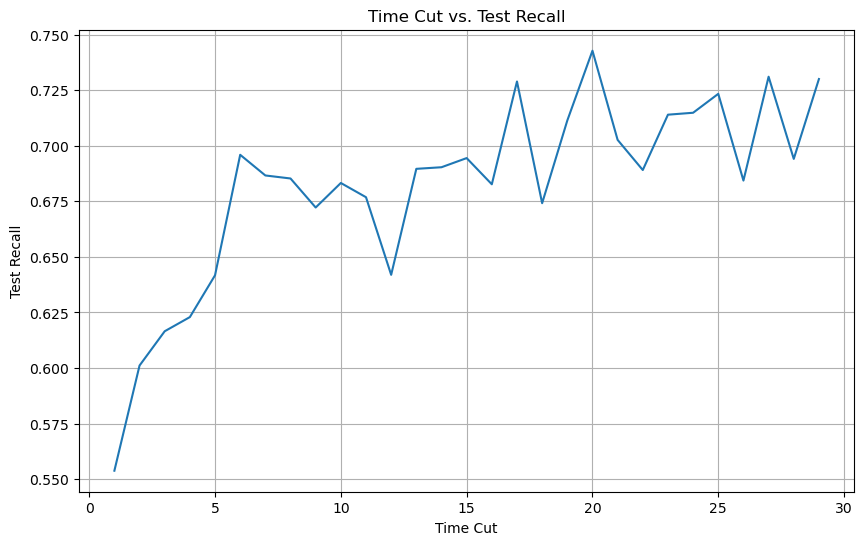

In [30]:
    # Ensure the metrics are numeric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=df.sort_values(by='start_time',ascending=True).iloc[-29:]
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_recall'] = pd.to_numeric(df['metrics.test_recall'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_recall', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()

In [29]:
class HAN(nn.Module):
    def __init__(self, dim_in, dim_out, dim_h=64, heads=4):
        super().__init__()
        self.han = HANConv(dim_in, dim_h, heads=heads,dropout=0.2, metadata=data.metadata())
        self.han2 = HANConv(dim_h, dim_h, heads=heads, dropout=0.2, metadata=data.metadata())
        self.linear = nn.Linear(dim_h, dim_out)

    def forward(self, x_dict, edge_index_dict):
        out = self.han(x_dict, edge_index_dict)
        out = self.han2(out, edge_index_dict)
        out = self.linear(out['id'])
        return out
    
@torch.no_grad()
def test(mask):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    acc = (pred[mask] == data['id'].y[mask]).sum() / mask.sum()
    return float(acc)

In [30]:
model = HAN(dim_in=-1, dim_out=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['id'].train_mask
    loss = F.cross_entropy(out[mask], data['id'].y[mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_acc = test(data['id'].train_mask)
        val_acc = test(data['id'].val_mask)
        print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

test_acc = test(data['id'].test_mask)
print(f'Test accuracy: {test_acc*100:.2f}%')

Epoch:   0 | Train Loss: 0.9255 | Train Acc: 63.67% | Val Acc: 64.00%
Epoch:  20 | Train Loss: 0.5235 | Train Acc: 77.09% | Val Acc: 79.00%
Epoch:  40 | Train Loss: 0.4322 | Train Acc: 78.80% | Val Acc: 78.33%
Epoch:  60 | Train Loss: 0.3749 | Train Acc: 82.94% | Val Acc: 83.00%
Epoch:  80 | Train Loss: 0.3278 | Train Acc: 84.58% | Val Acc: 83.67%
Epoch: 100 | Train Loss: 0.3015 | Train Acc: 87.15% | Val Acc: 83.33%
Epoch: 120 | Train Loss: 0.2716 | Train Acc: 88.29% | Val Acc: 84.00%
Epoch: 140 | Train Loss: 0.2424 | Train Acc: 89.29% | Val Acc: 85.33%
Epoch: 160 | Train Loss: 0.2179 | Train Acc: 91.08% | Val Acc: 84.67%
Epoch: 180 | Train Loss: 0.1896 | Train Acc: 92.79% | Val Acc: 85.67%
Epoch: 200 | Train Loss: 0.1682 | Train Acc: 93.93% | Val Acc: 86.67%
Epoch: 220 | Train Loss: 0.1455 | Train Acc: 94.93% | Val Acc: 86.33%
Epoch: 240 | Train Loss: 0.1186 | Train Acc: 96.22% | Val Acc: 87.00%
Epoch: 260 | Train Loss: 0.1091 | Train Acc: 96.79% | Val Acc: 87.67%
Epoch: 280 | Train L

In [31]:
test_mask = data['id'].test_mask | data['id'].val_mask
pred =model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
true_labels = data['id'].y[test_mask]
pred_labels = pred[test_mask]
precision_score(true_labels, pred_labels, average='macro')

0.8146117368109069

In [32]:
recall_score(true_labels, pred_labels, average='macro')

0.8015121136173768

In [20]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("HAN  2 layers 2024-09-05")

2024/09/08 15:08:48 INFO mlflow.tracking.fluent: Experiment with name 'HAN  2 layers 2024-09-08' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/16', creation_time=1725808128883, experiment_id='16', last_update_time=1725808128883, lifecycle_stage='active', name='HAN  2 layers 2024-09-08', tags={}>

In [66]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range(1,30,1):
    print(time_cut)
    processor = HeteroDataProcessor(file_path_replies, file_path_posts, time_cut)
    data = processor.process()

    model = HAN(dim_in=-1, dim_out=2)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
   
    with mlflow.start_run():

        for epoch in range(500):
            model.train()
            optimizer.zero_grad()
            out = model(data.x_dict, data.edge_index_dict)
            mask = data['id'].train_mask
            loss = F.cross_entropy(out[mask], data['id'].y[mask])
            loss.backward()
            optimizer.step()

        if epoch % 20 == 0:
            train_acc = test(data['id'].train_mask)
            val_acc = test(data['id'].val_mask)
            print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

        test_acc = test(data['id'].test_mask)
        print(f'Test accuracy: {test_acc*100:.2f}%')



        test_mask = data['id'].test_mask | data['id'].val_mask
        pred =model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
        true_labels = data['id'].y[test_mask]
        pred_labels = pred[test_mask]
        test_precision =precision_score(true_labels, pred_labels, average='macro')
        test_recall=recall_score(true_labels, pred_labels, average='macro')
        print(f'Test Recall: {test_recall*100:.2f}%')
        print(f'Test Precision: {test_precision*100:.2f}%')

        mlflow.log_metric("train_loss", loss.item(), step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("test_acc", test_acc)
        mlflow.log_metric("test_precision",  test_precision)
        mlflow.log_metric("test_recall",  test_recall)

            
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("epochs", 400)
        mlflow.log_metric("time_cut", time_cut)



        
            
        mlflow.pytorch.log_model(model, f"HAN_model_{time_cut}")


1


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 79.40%
Test Recall: 58.21%
Test Precision: 71.63%


2024/09/07 00:47:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.39%
Test Recall: 69.07%
Test Precision: 83.00%


2024/09/07 00:47:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.39%
Test Recall: 71.03%
Test Precision: 74.73%


2024/09/07 00:48:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.38%
Test Recall: 72.29%
Test Precision: 77.16%


2024/09/07 00:48:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


5


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.71%
Test Recall: 72.06%
Test Precision: 82.01%


2024/09/07 00:48:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


6


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.39%
Test Recall: 74.24%
Test Precision: 77.58%


2024/09/07 00:48:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


7


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.38%
Test Recall: 76.24%
Test Precision: 79.38%


2024/09/07 00:49:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


8


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.05%
Test Recall: 76.18%
Test Precision: 79.17%


2024/09/07 00:49:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


9


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.72%
Test Recall: 77.59%
Test Precision: 80.21%


2024/09/07 00:49:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


10


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.72%
Test Recall: 76.54%
Test Precision: 79.90%


2024/09/07 00:50:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


11


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 86.71%
Test Recall: 77.88%
Test Precision: 80.24%


2024/09/07 00:50:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


12


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.06%
Test Recall: 75.71%
Test Precision: 79.15%


2024/09/07 00:51:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


13


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.39%
Test Recall: 74.50%
Test Precision: 78.52%


2024/09/07 00:52:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


14


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.39%
Test Recall: 77.93%
Test Precision: 79.24%


2024/09/07 00:52:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


15


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 84.05%
Test Recall: 80.10%
Test Precision: 80.83%


2024/09/07 00:53:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


16


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 79.57%
Test Precision: 79.41%


2024/09/07 00:53:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


17


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.38%
Test Recall: 79.78%
Test Precision: 80.10%


2024/09/07 00:53:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


18


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.71%
Test Recall: 76.64%
Test Precision: 79.95%


2024/09/07 00:54:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


19


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 82.06%
Test Recall: 79.62%
Test Precision: 78.15%


2024/09/07 00:54:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


20


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.38%
Test Recall: 79.29%
Test Precision: 80.11%


2024/09/07 00:55:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


21


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 78.06%
Test Precision: 79.18%


2024/09/07 00:55:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


22


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 81.80%
Test Precision: 81.33%


2024/09/07 00:56:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


23


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.04%
Test Recall: 77.65%
Test Precision: 80.50%


2024/09/07 00:56:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


24


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.06%
Test Recall: 76.05%
Test Precision: 77.33%


2024/09/07 00:56:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


25


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 89.70%
Test Recall: 80.67%
Test Precision: 81.78%


2024/09/07 00:57:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


26


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 79.83%
Test Precision: 78.45%


2024/09/07 00:57:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


27


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 83.72%
Test Recall: 75.39%
Test Precision: 78.94%


2024/09/07 00:58:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


28


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 87.04%
Test Recall: 78.54%
Test Precision: 80.92%


2024/09/07 00:58:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


29


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 85.05%
Test Recall: 76.75%
Test Precision: 80.74%


2024/09/07 00:59:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [67]:
import mlflow

# Get the experiment ID or name
experiment_name = "HAN  2 layers 2024-09-05"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


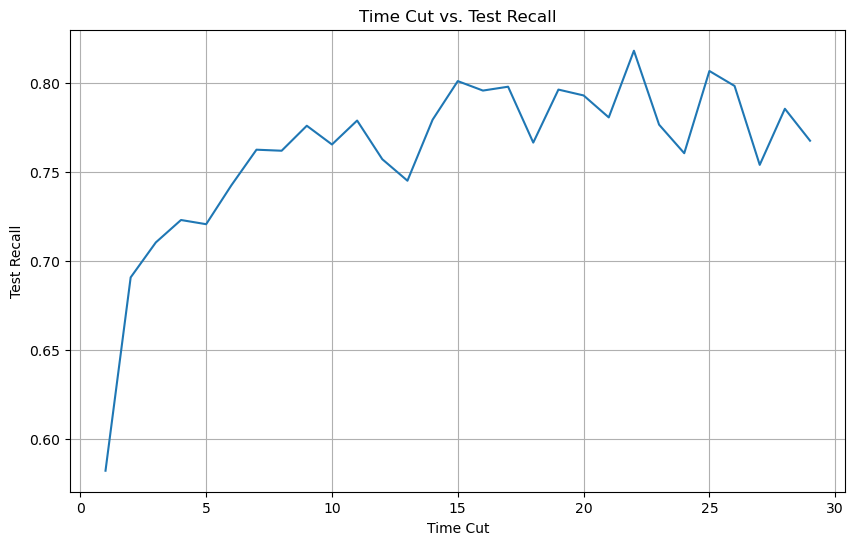

In [68]:
    # Ensure the metrics are numeric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_recall'] = pd.to_numeric(df['metrics.test_recall'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_recall', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()

In [ ]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("HAN  2 layers 2024-09-08")

In [ ]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range(1,30,1):
    print(time_cut)
    processor = HeteroDataProcessor(file_path_replies, file_path_posts, time_cut)
    data = processor.process()

    model = HAN(dim_in=-1, dim_out=2)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
   
    with mlflow.start_run():

        for epoch in range(500):
            model.train()
            optimizer.zero_grad()
            out = model(data.x_dict, data.edge_index_dict)
            mask = data['id'].train_mask
            loss = F.cross_entropy(out[mask], data['id'].y[mask])
            loss.backward()
            optimizer.step()

        if epoch % 20 == 0:
            train_acc = test(data['id'].train_mask)
            val_acc = test(data['id'].val_mask)
            print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

        test_acc = test(data['id'].test_mask)
        print(f'Test accuracy: {test_acc*100:.2f}%')



        test_mask = data['id'].test_mask | data['id'].val_mask
        pred =model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
        true_labels = data['id'].y[test_mask]
        pred_labels = pred[test_mask]
        test_precision =precision_score(true_labels, pred_labels, average='macro')
        test_recall=recall_score(true_labels, pred_labels, average='macro')
        print(f'Test Recall: {test_recall*100:.2f}%')
        print(f'Test Precision: {test_precision*100:.2f}%')

        mlflow.log_metric("train_loss", loss.item(), step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("test_acc", test_acc)
        mlflow.log_metric("test_precision",  test_precision)
        mlflow.log_metric("test_recall",  test_recall)

            
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("epochs", 400)
        mlflow.log_metric("time_cut", time_cut)



        
            
        mlflow.pytorch.log_model(model, f"HAN_model_{time_cut}")


1


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 81.40%
Test Recall: 61.15%
Test Precision: 79.18%


2024/09/08 15:09:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


Test accuracy: 80.07%
Test Recall: 68.27%
Test Precision: 73.99%


2024/09/08 15:09:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


In [25]:
import mlflow

# Get the experiment ID or name
experiment_name = "HAN  2 layers 2024-09-08"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


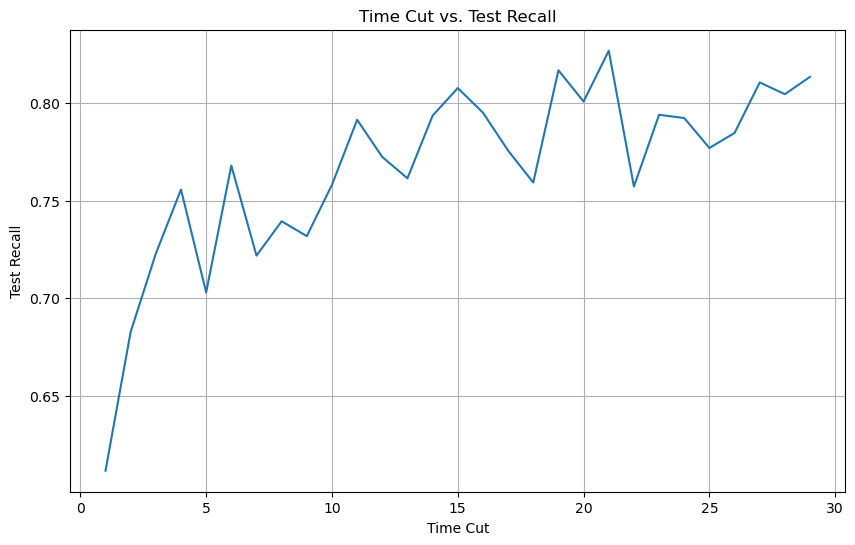

In [26]:
    # Ensure the metrics are numeric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_recall'] = pd.to_numeric(df['metrics.test_recall'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_recall', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()